---
title: 'Chapter 5: Image segmentation'
jupyter: python3
format:
  html:
    embed-resources: true
  pdf:
    documentclass: article
    toc: true
    fontsize: 12pt
    geometry:
      - top=1in
      - bottom=1in
      - left=1in
      - right=1in
      - heightrounded
---


# Introduction
After we have a binary mask with all the desired objects in the foreground, the
next step is to label each individual object with a unique ID. A segmentation
algorithm typically takes as an input image (can be binary or grayscale, but we
will focus on binary) and partitions it into distinct objects each with a
different id.  A segmentation algorithm does not modify the input image, but
generates a separate image with the object IDs. This image is called the label
image, and is of the same size as the input image. Each pixels in the image is
an number uniquely representing an object in the input image. This labels image
can then the used together with the input image to extract the desired
information about each object. 



# Connected components segmentation

Connected components segmentation labels each of the connected (touching)
foreground pixels as an object, i.e an object is entirely surrounded by
background pixels. This segmentation is most useful then the object or sparse
and not touching one another. If there are touching objects they will not be
separated and get labeled with the same ID. 


Number of segmented objects = 135


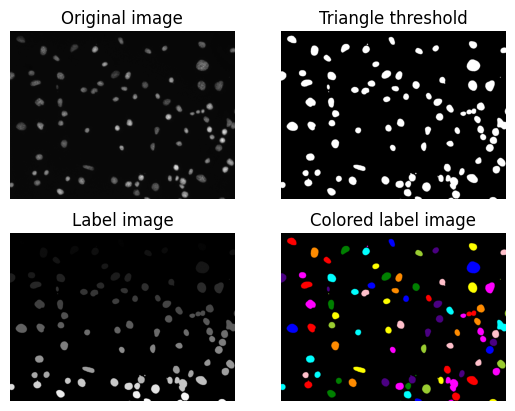

In [159]:
# Load the required libraries
import skimage as ski
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage as ndi

# Load the cell images
img = ski.io.imread("data/F01_202w2.TIF")


# Get the Triangle threshold
binary_thresh = ski.filters.threshold_triangle(img)

# Binary threshold the image
img_binary = img > binary_thresh

# Get the connected components segmentation
label_img = ski.morphology.label(img_binary)
# The number of segmented objects is the maximum value of the 
# label image
print('Number of segmented objects = ' + str(label_img.max()))

# Color the label image for visualization
label_img_overlay = ski.color.label2rgb(label_img)

# Plot the images
fig, ax =  plt.subplots(2, 2)
ax[0, 0].imshow(img, cmap = 'gray')
ax[0, 0].set_title('Original image')
ax[0, 1].imshow(img_binary, cmap = 'gray')
ax[0, 1].set_title('Triangle threshold')
ax[1, 0].imshow(label_img, cmap = 'gray')
ax[1, 0].set_title('Label image')
ax[1, 1].imshow(label_img_overlay)
ax[1, 1].set_title('Colored label image')
for a in ax.flatten():
    a.set_axis_off()

The label image typically contains a 0 for the background as well, i.e the
pixels that do not correspond to any object. As can the seen in the grayscale
image, each objects starting from the top right get labeled with a distinct
integer (thus represented as a shade of gray). The labels images are often
overlaid with the original image and/or pseudo-colored for better visualization
of the segmented objects. 



# Watershed segmentation

Watershed segmentation is a way to segment objects when they are touching one
another.  Watershed segments a grayscale image by treating the intensity of the
image as the height of a dam. Think of the bright regions of the image as
tall structures and dimmer regions as shorter structures. Watershed
segmentation starts flooding the image from the lowest regions (or regions
specified by the user), and when the water overflows into across a structure, a
segmentation boundary is created. Since we need the segmentation boundaries at
the object borders, the input image to watershed should be an image that has
largest intensity values the object boundaries and the smallest values at the
innermost regions of the cells.

## Distance transform
One way to get such an image from a binary image is to take a distance
transform.  For each foreground pixel, the distance transform calculates the
euclidean distance to the closest background pixel.  So the pixels that are
just adjacent to the background are going to get a value of 1, and the pixels
at the center of objects are going to get the highest value (the radius for a
perfectly circular object). 

For watershed segmentation we need the center of objects to have the lowest
value and the boundaries of the objects to have the largest values, we can get
such an image by simply inverting the distance transformed image. 

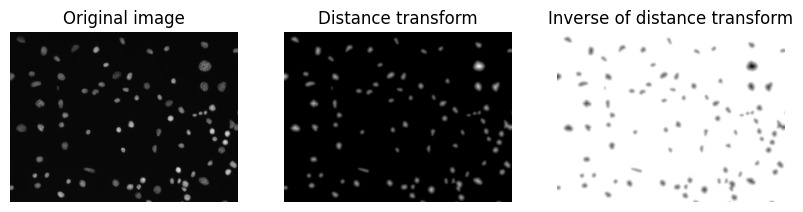

In [160]:
# Get the distance transform
# Returns a float image, but let's not get into the details here
img_dist = ndi.distance_transform_edt(img_binary)

# Invert the distance
img_dist_invert = ski.util.invert(img_dist)

# Plot the images
fig, ax =  plt.subplots(1, 3, figsize = (10, 4))
ax[0].imshow(img, cmap = 'gray')
ax[0].set_title('Original image')
ax[1].imshow(img_dist, cmap = 'gray')
ax[1].set_title('Distance transform')
ax[2].imshow(img_dist_invert, cmap = 'gray')
ax[2].set_title('Inverse of distance transform')
for a in ax:
    a.set_axis_off()

## Image maxima and minima
Furthermore, we can also provide marker (seed) points to watershed
segmentation. These marker regions are where the folding starts from. From our
distance image, the ideal seed points would be the locations that are at the
center of the objects, i.e with the smallest distance. These regions with the
smallest values are surrounded by regions of higher values, i.e they are the
minima intensity regions in an image. They can be detected with the h-minima
algorithm. The h here refer to the minimum height to retain in the output.
Smaller value of h will retain more minima and larger ones will will retain few
ones. Therefore, the higher the h, just the larger objects that have a radial
distance more than h will be retained.

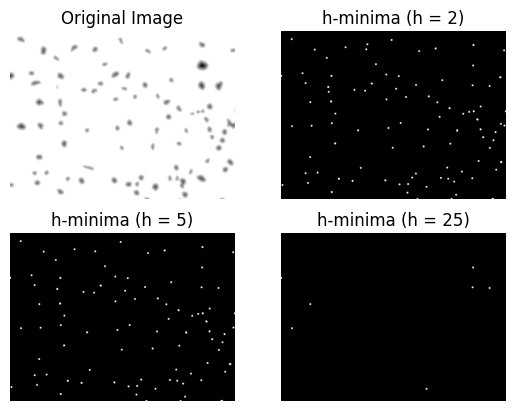

In [161]:
# Get the h-minima for different values of h
local_min_h2 = ski.morphology.h_minima(img_dist_invert, h = 2)
local_min_h5 = ski.morphology.h_minima(img_dist_invert, h = 5)
local_min_h25 = ski.morphology.h_minima(img_dist_invert, h = 25)

# The h-minima are 1-pixel each. 
# Just making them bigger for visualization by dilation 
se = ski.morphology.ellipse(5, 5)
local_min_h2_big = ski.morphology.binary_dilation(local_min_h2, se)
local_min_h5_big = ski.morphology.binary_dilation(local_min_h5, se)
local_min_h25_big = ski.morphology.binary_dilation(local_min_h25, se)

# Plot the images
fig, ax =  plt.subplots(2, 2)
ax[0, 0].imshow(img_dist_invert, cmap = 'gray')
ax[0, 0].set_title('Original Image')
ax[0, 1].imshow(local_min_h2_big, cmap = 'gray')
ax[0, 1].set_title('h-minima (h = 2)')
ax[1, 0].imshow(local_min_h5_big, cmap = 'gray')
ax[1, 0].set_title('h-minima (h = 5)')
ax[1, 1].imshow(local_min_h25_big, cmap = 'gray')
ax[1, 1].set_title('h-minima (h = 25)')
for a in ax.flatten():
    a.set_axis_off()

Now that we have the distance transformed image and the h-minima image, we can
use these for the watershed segmentation. Notice that the touching nucleii are
separated out. The compactness parameter to watershed segmentation is used
to adjust the smoothness in segmentation boundaries. 

Number of segmented objects = 94


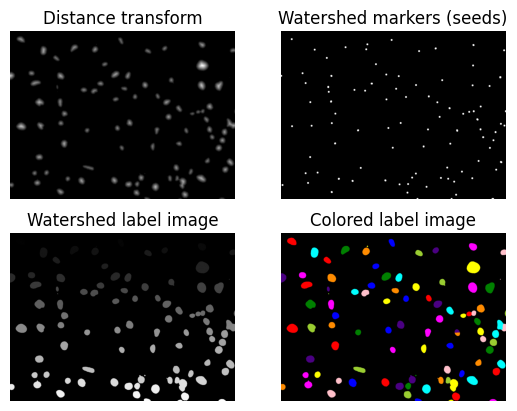

In [162]:
# The marker seeds need to be labels with a unique id.
# We can get the connected components of the h-minima to label it
nuc_seed_label = ski.morphology.label(local_min_h2)

# Watershed segmentation
label_img = ski.segmentation.watershed(img_dist_invert, 
                markers = nuc_seed_label, mask = img_binary, compactness = 0)
print('Number of segmented objects = ' + str(label_img.max()))

# Color the label image for visualization
label_img_overlay = ski.color.label2rgb(label_img)

# Write the manipulated image to file
ski.io.imsave('data/out.tif', label_img_overlay, check_contrast = False)

# Plot the images
fig, ax =  plt.subplots(2, 2)
ax[0, 0].imshow(img_dist, cmap = 'gray')
ax[0, 0].set_title('Distance transform')
ax[0, 1].imshow(local_min_h2_big, cmap = 'gray')
ax[0, 1].set_title('Watershed markers (seeds)')
ax[1, 0].imshow(label_img, cmap = 'gray')
ax[1, 0].set_title('Watershed label image')
ax[1, 1].imshow(label_img_overlay)
ax[1, 1].set_title('Colored label image')
for a in ax.flatten():
    a.set_axis_off()